# Classifying Emotions from Text

In [1]:
!pip install -q evaluate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate
from datasets import Dataset
from sklearn.metrics import confusion_matrix, classification_report


import transformers
from transformers import EarlyStoppingCallback
import evaluate
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaPreTrainedModel, RobertaModel
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from tqdm import tqdm

Pull Data

In [3]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")
emotions = pd.concat([df1, df2, df3], ignore_index = True)
emotions.head()

--2025-07-31 13:13:57--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.250.4.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  7.16MB/s    in 1.9s    

2025-07-31 13:13:59 (7.16 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-07-31 13:13:59--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.250.4.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 2

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


Dataset shape: (211225, 37)
Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_

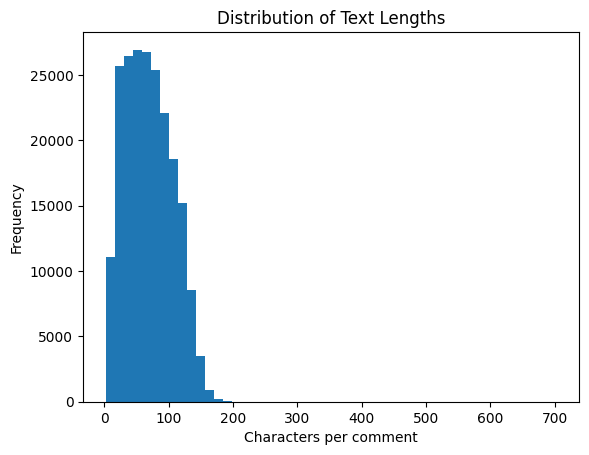

In [4]:
# Check shape and columns
print(f"Dataset shape: {emotions.shape}")
print(emotions.columns)

# Inspect the first few rows
print(emotions.head())

# Check for missing values
print(emotions.isnull().sum())

# Distribution of text lengths (number of tokens or characters)
emotions['text_length'] = emotions['text'].apply(len)
plt.hist(emotions['text_length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters per comment")
plt.ylabel("Frequency")
plt.show()

### Data Cleaning
* A text can have more than one row with only one flag for the list of emtion.   
* Making sure we have distinct rows of text where there can be more than one emotion flagged per row
* Removing rows that have no labels

In [5]:
# Columns to drop
drop_cols = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id','example_very_unclear']

# Find columns that exist in the DataFrame
existing_cols_to_drop = [col for col in drop_cols if col in emotions.columns]

emotions.drop(existing_cols_to_drop, axis = 1, inplace = True)

# shape of data
print("SHAPE BEFORE MULTI-LABELS")
print("Shape of Emotions Dataset", emotions.shape)
print("Number of Unique Texts", emotions[['text','text_length']].nunique())

# Grouping by text and aggregated emtion flags
label_cols = emotions.columns.difference(['text','text_length'])
emotions_multi = emotions.groupby('text')[label_cols].max().reset_index()

print("\nSHAPE AFTER MULTI-LABELS")
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Number of Unique Texts", emotions_multi['text'].nunique())

SHAPE BEFORE MULTI-LABELS
Shape of Emotions Dataset (211225, 30)
Number of Unique Texts text           57732
text_length      192
dtype: int64

SHAPE AFTER MULTI-LABELS
Shape of Emotions Dataset (57732, 29)
Number of Unique Texts 57732


In [ ]:
emotions_multi.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
# Removing rows that have no labels
emotions_multi = emotions_multi[emotions_multi[label_cols].any(axis=1)]
print("Shape of Emotions Dataset", emotions_multi.shape)

Shape of Emotions Dataset (57730, 29)


### Spliting data into Train, Test, and Validation

* **60% - Train:** Used to train the model and update its weights   
* **20% - Validation:** Used to tune hyperparameters (like learning rate, batch size, epochs) and monitor for overfitting.
* **20% - Test:** Evaluate final model's performance on unseen data after all tuning is done

In [7]:
# Creating relevant columns for labels
# Y value
label_cols = emotions.columns.difference(['text','text_length'])

# Splitting Train, Test, Validation
x_train, x_temp, y_train, y_temp = train_test_split(emotions_multi['text'], emotions_multi[label_cols], test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

# Combine features and labels into one dataframe for each split
train_emotions = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_emotions   = pd.concat([x_val.reset_index(drop=True),   y_val.reset_index(drop=True)],   axis=1)
test_emotions  = pd.concat([x_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_emotions)
val_dataset = Dataset.from_pandas(val_emotions)
test_dataset = Dataset.from_pandas(test_emotions)


## Exploratory Data Analysis

Continuing to use train dataset for data exploration

**Simran Exploration Takeaways:**
* There is some class imbalance when it comes to labels, many text are labeled as neutral. Which makes sense since many text can just be regular comments that don't always need to express emtions.
* Many text have 2 emotions labels

In [8]:
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Shape of Train Dataset", x_train.shape, y_train.shape)
print("Shape of Test Dataset", x_test.shape, y_test.shape)
print("Shape of Validation Dataset", x_val.shape, y_val.shape)

Shape of Emotions Dataset (57730, 29)
Shape of Train Dataset (34638,) (34638, 28)
Shape of Test Dataset (11546,) (11546, 28)
Shape of Validation Dataset (11546,) (11546, 28)


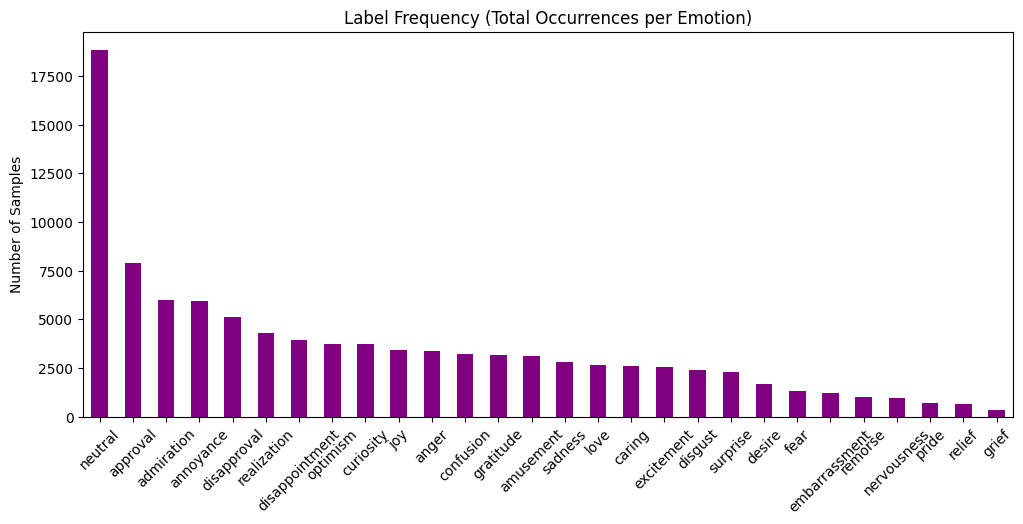

In [ ]:
# Exploring label frequency - seeing which emotions are more common across all text

label_counts = y_train.sum().sort_values(ascending=False)

plt.figure(figsize=(12,5))
label_counts.plot(kind='bar', color='purple')
plt.title("Label Frequency (Total Occurrences per Emotion)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

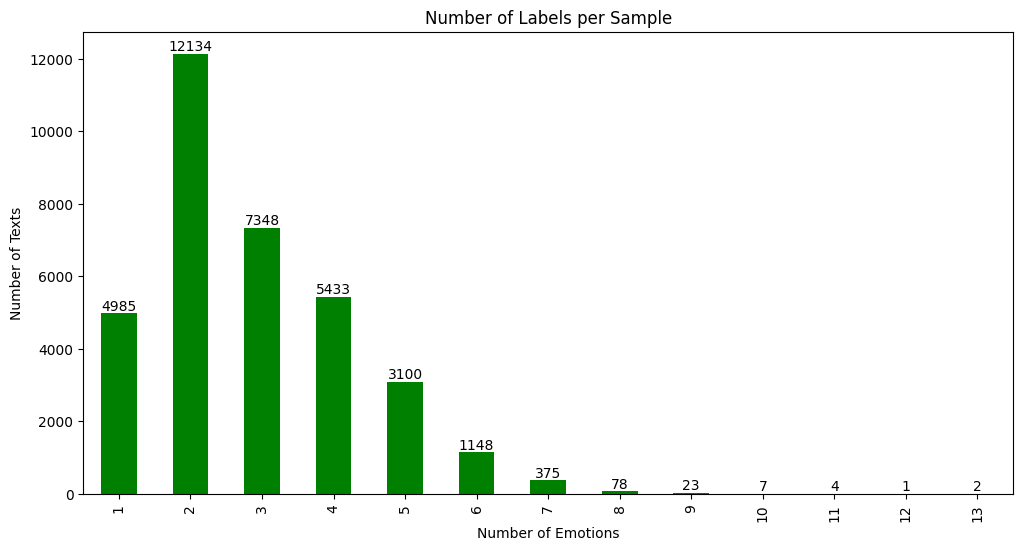

count    34638.000000
mean         2.858854
std          1.413529
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
dtype: float64


In [ ]:
# Seeing number of labels a typical text has

num_labels_per_sample = y_train.sum(axis=1)
counts = num_labels_per_sample.value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='green')
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Number of Labels per Sample")
plt.xlabel("Number of Emotions")
plt.ylabel("Number of Texts")
plt.show()

print(num_labels_per_sample.describe())


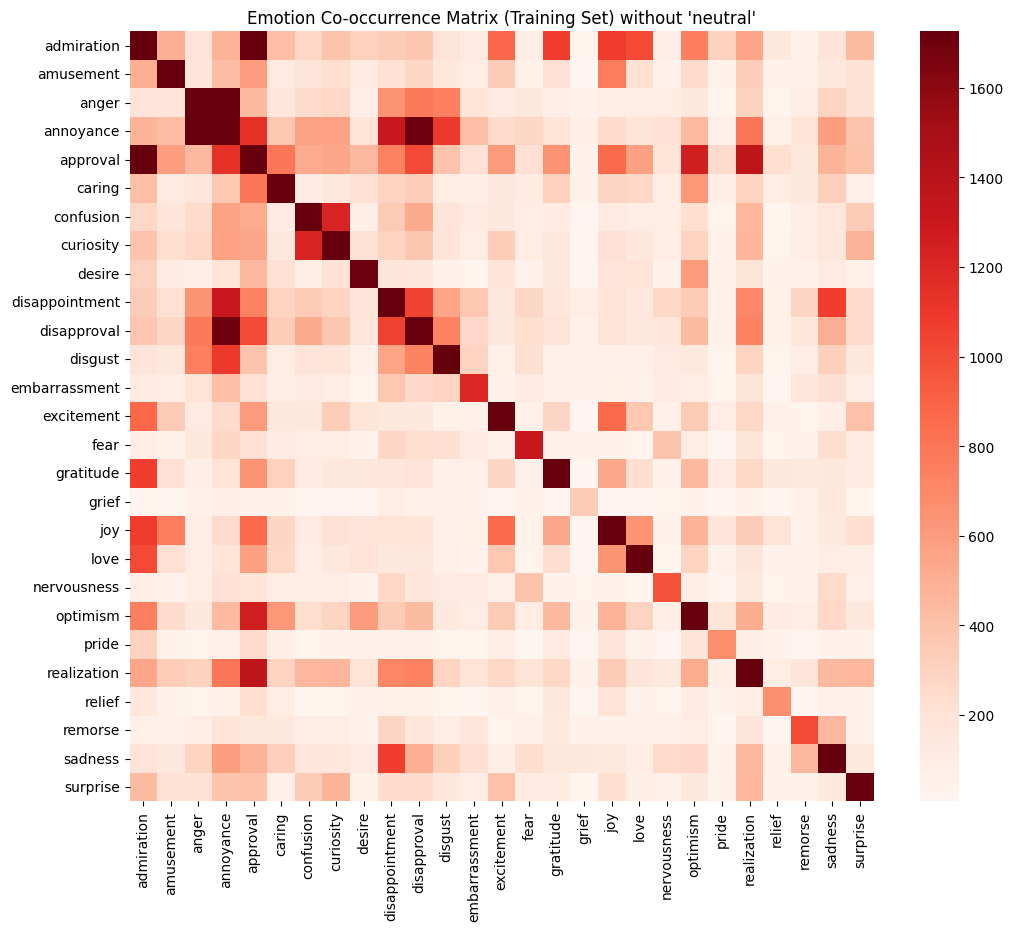

In [ ]:
# emotion co-occurence heatmap, remove "neutral" so it won't dominate the colors

import seaborn as sns

emotions_wo_neutral = y_train.columns.difference(['neutral'])
emotion_cooccur = y_train[emotions_wo_neutral].T.dot(y_train[emotions_wo_neutral])

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_cooccur, cmap="Reds", xticklabels=True, yticklabels=True, vmax=emotion_cooccur.quantile(0.95).max())
plt.title("Emotion Co-occurrence Matrix (Training Set) without 'neutral'")
plt.show()


In [ ]:
# find top co-occurring pairs (excluding neutral)
top_pairs = emotion_cooccur.where(np.triu(np.ones(emotion_cooccur.shape), k=1).astype(bool))
top_pairs = top_pairs.stack().sort_values(ascending=False).reset_index().rename(columns ={'level_0':'emotion_1', 'level_1':'emotion_2',0:'co-orurrence'})

print(top_pairs.head(10))

    emotion_1       emotion_2  co-orurrence
0  admiration        approval        1785.0
1       anger       annoyance        1738.0
2   annoyance     disapproval        1698.0
3    approval     realization        1364.0
4   annoyance  disappointment        1307.0
5    approval        optimism        1260.0
6   confusion       curiosity        1224.0
7   annoyance        approval        1143.0
8   annoyance         disgust        1091.0
9  admiration             joy        1076.0


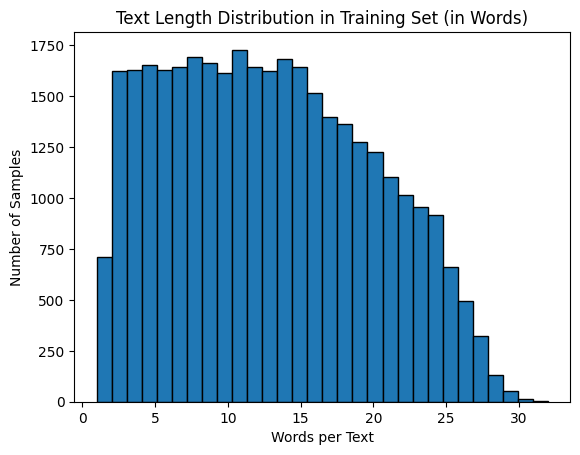

count    34638.000000
mean        12.984006
std          6.698078
min          1.000000
25%          7.000000
50%         13.000000
75%         18.000000
max         32.000000
Name: text, dtype: float64


In [ ]:
# Understaning the size of text inputs

# Calculate number of words per text
x_train_lengths = x_train.str.split().apply(len)

# Plot histogram of text lengths
x_train_lengths.plot(kind='hist', bins=30, edgecolor='black')
plt.title("Text Length Distribution in Training Set (in Words)")
plt.xlabel("Words per Text")
plt.ylabel("Number of Samples")
plt.show()

# Describe text length stats
print(x_train_lengths.describe())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

count    34638.000000
mean        19.350424
std          8.679747
min          3.000000
50%         19.000000
90%         31.000000
95%         34.000000
99%         38.000000
max        316.000000
Name: text, dtype: float64


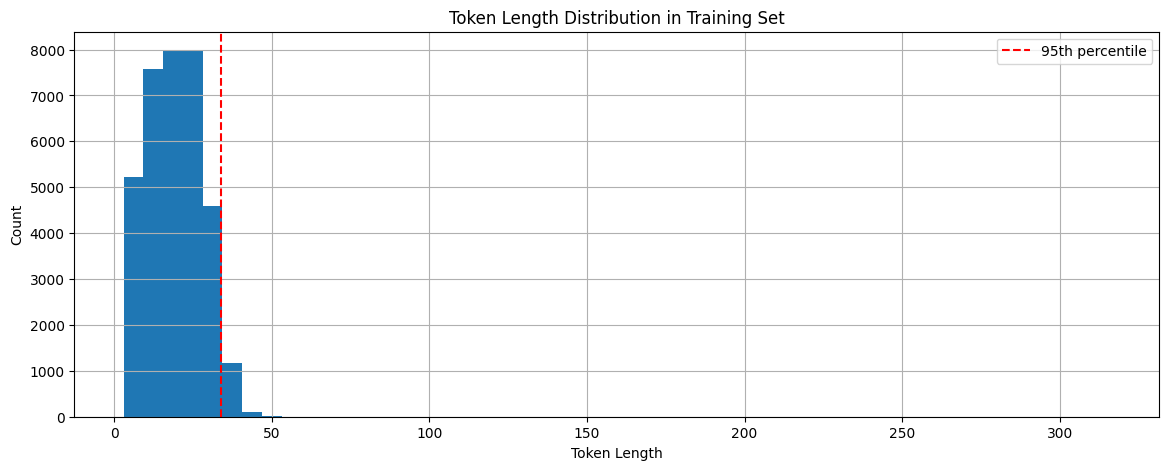

In [ ]:
# token length analysis - help to decide the max sequence length

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
token_lengths = x_train.apply(lambda x: len(tokenizer.encode(x, truncation=False)))

# summary statistics
print(token_lengths.describe(percentiles=[0.9, 0.95, 0.99]))

plt.figure(figsize=(14, 5))
token_lengths.hist(bins=50)
plt.axvline(token_lengths.quantile(0.95), color='red', linestyle='dashed', label='95th percentile')
plt.title("Token Length Distribution in Training Set")
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.legend()
plt.show()

# Testing the 4 different experiments using BERT
### BERT is our baseline we are using to test mode modern models

| Experiment # | Name                             | Description                                                                 |
|--------------|----------------------------------|------------------------------------------------------------------------------|
| 1            | Simple Baseline                  | Creating a simple model without adding weights, thresholds, or freezing layers. |
| 2            | Simple Baseline plus Thresholds  | Optimize thresholds per label for F1 using baseline model                   |
| 3            | Weighted Loss                    | Adding class weights to handle imbalance                                    |
| 4            | Weighted + Threshold             | Combines class weights and threshold tuning (tuned using weighted model)    |
| 5            | Weighted + Threshold + Freezing Layers | Adds layer freezing to reduce overfitting and improve generalization   |


In [9]:
from torch.nn import BCEWithLogitsLoss
from transformers import PreTrainedModel

# compute label frequency
label_freq = y_train.sum() / len(y_train)

# compute pos_weight
pos_weight = (1.0 - label_freq) / label_freq
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)

class Multi_Label_With_Weights(nn.Module):
    def __init__(self, base_model: PreTrainedModel, pos_weight: torch.Tensor):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        supported_keys = {"token_type_ids","position_ids","head_mask","inputs_embeds",
            "output_attentions","output_hidden_states","return_dict"}
        filtered_kwargs = {k: v for k, v in kwargs.items() if k in supported_keys}

        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **filtered_kwargs)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


In [10]:
MAX_SEQUENCE_LENGTH = 35

In [11]:
label_cols = emotions.columns.difference(['text','text_length'])  # Skip the 'text' and 'text_length' column

# Preprocessing function that accepts both data and tokenizer
def preprocess_emotions(data, tokenizer):
    """
    Function tokenizes text and converts the emotion labels into a list of floats
    """
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Process multi-label binary targets
    encoded["labels"] = [
        [float(data[label][i]) for label in label_cols]
        for i in range(len(data["text"]))
    ]

    return encoded

###########################################################################
# Compute Metric Baseline
def compute_metrics(p):
    predictions, labels = p
    predictions = (predictions > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    subset_accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')
    f1 = f1_score(labels, predictions, average='micro')

    # Return all the metrics
    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

###########################################################################

# Function to compute per-epoch metrics for each label
def compute_per_label_metrics(predictions, labels):
    label_metrics = {}
    for idx, label in enumerate(label_cols):
        precision = precision_score(labels[:, idx], predictions[:, idx], zero_division=0)
        recall = recall_score(labels[:, idx], predictions[:, idx], zero_division=0)
        f1 = f1_score(labels[:, idx], predictions[:, idx], zero_division=0)
        label_metrics[label] = {"precision": precision, "recall": recall, "f1": f1}
    return label_metrics


################################################################################
# Compute Metric Fine Tuned
def best_threshold_compute_metrics(p):
    global best_thresholds
    predictions, labels = p

    # Load the best thresholds if they exist
    try:
        best_thresholds = np.load("best_thresholds.npy")
    except FileNotFoundError:
        print("Best thresholds not found. Using default 0.5 thresholds.")
        best_thresholds = None

    # Apply sigmoid if not already applied
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Use optimized thresholds if available
    if best_thresholds is not None:
        binary_predictions = np.zeros_like(predictions)
        for i, thresh in enumerate(best_thresholds):
            binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
    else:
        binary_predictions = (predictions >= 0.5).astype(int)

    # Calculate metrics
    subset_accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions, average='micro')
    recall = recall_score(labels, binary_predictions, average='micro')
    f1 = f1_score(labels, binary_predictions, average='micro')

    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


##########################################################################
# Evaluation per Label
def label_evaluation(trainer, preprocessed_dev_data, metrics):

    # Final evaluation on validation set
    final_val_metrics = trainer.evaluate(preprocessed_dev_data)

    print("\nFinal Validation Per-Label Metrics:")
    per_label_metrics = {
        "Label": [],
        "Precision": [],
        "Recall": [],
        "F1": []
    }

    output = trainer.predict(preprocessed_dev_data)
    predictions = output.predictions
    labels = output.label_ids
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    if metrics == compute_metrics:
      binary_predictions = (predictions > 0.5).astype(int)
    else:
      if best_thresholds is not None:
          binary_predictions = np.zeros_like(predictions)
          for i, thresh in enumerate(best_thresholds):
              binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
      else:
          binary_predictions = (predictions >= 0.5).astype(int)

     # Compute metrics per label
    label_metrics = compute_per_label_metrics(binary_predictions, labels)


    for label, metrics in label_metrics.items():
        per_label_metrics["Label"].append(label)
        per_label_metrics["Precision"].append(metrics["precision"])
        per_label_metrics["Recall"].append(metrics["recall"])
        per_label_metrics["F1"].append(metrics["f1"])

    # Create a DataFrame for per-label metrics
    df = pd.DataFrame(per_label_metrics)
    print(df)

    return df


###########################################################################

# Use a wrapper function to pass the tokenizer to the preprocess function
def preprocess_with_tokenizer(batch, tokenizer):
    return preprocess_emotions(batch, tokenizer)

###########################################################################

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   training_arguments=None,
                                   batch_size=16,
                                   num_epochs=2,
                                   metrics= compute_metrics):
    """
    Preprocess the data using the given tokenizer.
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """
    # Preprocess the data
    preprocessed_train_data = train_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Set the training arguments if not provided
    if training_arguments is None:
        training_args = TrainingArguments(
            output_dir="emotions_model",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            eval_strategy="epoch",
            save_strategy="epoch",
            report_to='none'
        )
    else:
        training_args = training_arguments

    # Set up the trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        tokenizer=tokenizer,
        compute_metrics=metrics
    )

    # Train the model
    trainer.train()

    label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)


    return trainer, preprocessed_dev_data, label_eval

###########################################################################


# def fine_tune_classif_model_freeze_layers(classification_model,
#                                           tokenizer,
#                                           train_data,
#                                           dev_data,
#                                           layers_to_train=["classifier."],
#                                           max_sequence_length=MAX_SEQUENCE_LENGTH,
#                                           batch_size=16,
#                                           num_epochs=2,
#                                           metrics=compute_metrics):
#     """
#     Fine-tune a classification model while freezing all layers except those specified
#     in layers_to_train (partial substring match on parameter names).
#     """

#     # Preprocess the datasets with the tokenizer
#     preprocessed_train_data = train_data.map(
#         preprocess_with_tokenizer,
#         batched=True,
#         fn_kwargs={'tokenizer': tokenizer}
#     )
#     preprocessed_dev_data = dev_data.map(
#         preprocess_with_tokenizer,
#         batched=True,
#         fn_kwargs={'tokenizer': tokenizer}
#     )

#     # Freeze all layers except those matching substrings in layers_to_train
#     for name, param in classification_model.named_parameters():
#       if not any(layer_name in name for layer_name in layers_to_train):
#         param.requires_grad = False

#     # Define training arguments
#     training_args = TrainingArguments(
#         output_dir="bert_fine_tuned_freeze_emotions",
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         num_train_epochs=num_epochs,
#         eval_strategy="epoch",
#         save_strategy="epoch",
#         report_to='none'
#     )

#     # Define Trainer
#     trainer = Trainer(
#         model=classification_model,
#         args=training_args,
#         train_dataset=preprocessed_train_data,
#         eval_dataset=preprocessed_dev_data,
#         compute_metrics=metrics
#     )
#     # Train the model
#     trainer.train()

#     label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)

#     return trainer, preprocessed_dev_data, label_eval

###########################################################################


# def calc_label_metrics(label, y_true, y_pred, threshold):
#     return {
#         "label": label,
#         "threshold": threshold,
#         "f1": f1_score(y_true, y_pred, zero_division=0),
#     }

# def optimize_thresholds_verbose(predictions, labels, label_names):
#     threshold_results = {}
#     for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
#         threshold = t / 100
#         y_preds_all = (predictions > threshold).astype(int)
#         threshold_results[threshold] = []
#         for label_index, label in enumerate(label_names):
#             y_true = labels[:, label_index]
#             y_pred = y_preds_all[:, label_index]
#             threshold_results[threshold].append(
#                 calc_label_metrics(label, y_true, y_pred, threshold)
#             )

#     # Find best threshold per label
#     best = {label: {"f1": -1, "result": None} for label in label_names}
#     for threshold, results in threshold_results.items():
#         for result in results:
#             label = result["label"]
#             if result["f1"] > best[label]["f1"]:
#                 best[label] = {
#                     "f1": result["f1"],
#                     "result": result,
#                 }

#     # Create DataFrame
#     results = [b["result"] for b in best.values()]
#     df = pd.DataFrame(results, index=[r["label"] for r in results])

#     # Save best thresholds for future use
#     np.save("best_thresholds.npy", df["threshold"].values)

#     return df


##### BERT Baseline **before** Weights Applied

In [12]:
# Baseline Model - BERT Model before Weights Applied

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

bert_model_no_weights = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")

trainer, preprocessed_val_data, bert_noWeight_label_eval_val = fine_tune_classification_model(bert_model_no_weights, bert_tokenizer, train_dataset, val_dataset)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-97566448.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.208700,0.203780,0.141434,0.801257,0.314075,0.451265
2,0.186100,0.197171,0.148796,0.781857,0.360081,0.493078


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Final Validation Per-Label Metrics:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


             Label  Precision    Recall        F1
0       admiration   0.737567  0.637164  0.683699
1        amusement   0.868545  0.687094  0.767237
2            anger   0.624526  0.434095  0.512182
3        annoyance   0.551515  0.360753  0.436189
4         approval   0.596563  0.276765  0.378112
5           caring   0.609412  0.294318  0.396935
6        confusion   0.624782  0.344231  0.443893
7        curiosity   0.680144  0.636134  0.657403
8           desire   0.707317  0.258467  0.378590
9   disappointment   0.572632  0.206844  0.303911
10     disapproval   0.577861  0.367542  0.449307
11         disgust   0.599359  0.237310  0.340000
12   embarrassment   0.500000  0.002564  0.005102
13      excitement   0.636964  0.221330  0.328511
14            fear   0.702811  0.419664  0.525526
15       gratitude   0.887237  0.689124  0.775731
16           grief   0.000000  0.000000  0.000000
17             joy   0.672441  0.367786  0.475501
18            love   0.871720  0.684211  0.766667


In [13]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)


bert_noWeight_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.1985568106174469, 'eval_subset_accuracy': 0.15078815174086263, 'eval_precision': 0.7777558666929599, 'eval_recall': 0.3580897040130743, 'eval_f1': 0.49039477774323903, 'eval_runtime': 24.2896, 'eval_samples_per_second': 475.347, 'eval_steps_per_second': 29.725, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Final Validation Per-Label Metrics:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


             Label  Precision    Recall        F1
0       admiration   0.739334  0.644094  0.688435
1        amusement   0.851401  0.685294  0.759370
2            anger   0.622423  0.434743  0.511924
3        annoyance   0.579521  0.388889  0.465442
4         approval   0.589922  0.288805  0.387771
5           caring   0.631336  0.313143  0.418640
6        confusion   0.586817  0.330616  0.422943
7        curiosity   0.714523  0.655750  0.683876
8           desire   0.688995  0.250435  0.367347
9   disappointment   0.570787  0.187731  0.282536
10     disapproval   0.561955  0.378601  0.452406
11         disgust   0.671010  0.246411  0.360455
12   embarrassment   0.000000  0.000000  0.000000
13      excitement   0.575092  0.177201  0.270923
14            fear   0.669202  0.431373  0.524590
15       gratitude   0.874842  0.663471  0.754635
16           grief   0.000000  0.000000  0.000000
17             joy   0.681282  0.366274  0.476415
18            love   0.849315  0.721769  0.780365


In [14]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['curiosity', 'neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


#### BERT Baseline with Thresholds applied [BEST MODEL]



In [15]:
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df



predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.36it/s]


In [16]:
best_model_threshold = np.load("best_thresholds.npy")

In [17]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.40,0.689158
amusement,amusement,0.50,0.767237
anger,anger,0.25,0.552124
annoyance,annoyance,0.25,0.509735
approval,approval,0.25,0.506974
caring,caring,0.30,0.481504
confusion,confusion,0.25,0.537407
curiosity,curiosity,0.35,0.686916
desire,desire,0.25,0.443636
disappointment,disappointment,0.25,0.439773


In [18]:
# Baseline Model - BERT Model with Thresholds from baseline

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

bert_model_no_weights = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")

trainer_best, preprocessed_val_data, bert_onlyThreshold_label_eval_val = fine_tune_classification_model(bert_model_no_weights, bert_tokenizer, train_dataset, val_dataset, metrics=best_threshold_compute_metrics)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-97566448.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.209500,0.203714,0.087909,0.548862,0.587831,0.567678
2,0.186800,0.196830,0.093452,0.531662,0.637212,0.579672


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Final Validation Per-Label Metrics:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


             Label  Precision    Recall        F1
0       admiration   0.686475  0.693582  0.690010
1        amusement   0.874396  0.672238  0.760105
2            anger   0.495514  0.630931  0.555083
3        annoyance   0.422987  0.627354  0.505288
4         approval   0.423400  0.630600  0.506634
5           caring   0.500000  0.438636  0.467312
6        confusion   0.461436  0.667308  0.545597
7        curiosity   0.650478  0.742857  0.693605
8           desire   0.479920  0.426025  0.451369
9   disappointment   0.378442  0.491255  0.427531
10     disapproval   0.469697  0.591885  0.523759
11         disgust   0.407816  0.516497  0.455767
12   embarrassment   0.273810  0.353846  0.308725
13      excitement   0.367909  0.520642  0.431149
14            fear   0.703557  0.426859  0.531343
15       gratitude   0.882280  0.685274  0.771398
16           grief   0.078471  0.354545  0.128501
17             joy   0.525773  0.527132  0.526452
18            love   0.816537  0.723112  0.766990


In [19]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer_best.evaluate(preprocessed_test_data)
print(test_results)

bert_onlyThreshold_label_eval_test = label_evaluation(trainer_best, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.19832339882850647, 'eval_subset_accuracy': 0.09180668629828512, 'eval_precision': 0.5273882780187632, 'eval_recall': 0.6328914714605653, 'eval_f1': 0.5753432195229318, 'eval_runtime': 24.3118, 'eval_samples_per_second': 474.913, 'eval_steps_per_second': 29.698, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Final Validation Per-Label Metrics:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


             Label  Precision    Recall        F1
0       admiration   0.710913  0.689919  0.700258
1        amusement   0.859473  0.671569  0.753990
2            anger   0.453753  0.609361  0.520169
3        annoyance   0.443009  0.668616  0.532919
4         approval   0.414128  0.614042  0.494650
5           caring   0.503193  0.450286  0.475271
6        confusion   0.460908  0.662138  0.543494
7        curiosity   0.661465  0.742574  0.699677
8           desire   0.477495  0.424348  0.449355
9   disappointment   0.373933  0.485588  0.422508
10     disapproval   0.461538  0.585538  0.516196
11         disgust   0.425344  0.517943  0.467098
12   embarrassment   0.256000  0.308434  0.279781
13      excitement   0.363262  0.497743  0.420000
14            fear   0.650558  0.428922  0.516987
15       gratitude   0.873908  0.671141  0.759219
16           grief   0.099119  0.409091  0.159574
17             joy   0.515343  0.517679  0.516508
18            love   0.803659  0.767171  0.784991


In [20]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer_best.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'excitement', 'joy', 'realization', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'grief', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['approval', '

#### BERT Baseline **after** Weights Applied

In [ ]:
# Baseline Model - BERT with weights

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")
bert_withWeight_model = Multi_Label_With_Weights(base_model=bert_model, pos_weight=pos_weight_tensor)

trainer, preprocessed_val_data, bert_withWeights_label_eval_val = fine_tune_classification_model(bert_withWeight_model, bert_tokenizer, train_dataset, val_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-97566448.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.835700,0.814039,0.041486,0.397777,0.640892,0.490882
2,0.693200,0.799313,0.056037,0.405141,0.636878,0.495241



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.499690  0.833851  0.624903
1        amusement   0.477784  0.808728  0.600690
2            anger   0.339637  0.804921  0.477705
3        annoyance   0.370408  0.729435  0.491322
4         approval   0.376539  0.661731  0.479967
5           caring   0.292479  0.715909  0.415293
6        confusion   0.330340  0.813462  0.469869
7        curiosity   0.478137  0.845378  0.610808
8           desire   0.221786  0.704100  0.337319
9   disappointment   0.265980  0.765779  0.394825
10     disapproval   0.338661  0.809069  0.477465
11         disgust   0.234550  0.799492  0.362694
12   embarrassment   0.116531  0.661538  0.198157
13      excitement   0.221928  0.768349  0.344384
14            fear   0.264167  0.760192  0.392084
15       gratitude   0.456784  0.874880  0.600198
16           grief   0.092522  0.663636  0.162403
17             joy   0.292591  0.806202  0.429358
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)

print(test_results)

bert_withWeight_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.7982816696166992, 'eval_subset_accuracy': 0.051099948033951154, 'eval_precision': 0.40763361720164926, 'eval_recall': 0.6403062768597543, 'eval_f1': 0.49813995102655867, 'eval_runtime': 24.9323, 'eval_samples_per_second': 463.095, 'eval_steps_per_second': 28.958, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.513396  0.839104  0.637031
1        amusement   0.467503  0.803922  0.591204
2            anger   0.317170  0.794779  0.453402
3        annoyance   0.384840  0.771930  0.513619
4         approval   0.370258  0.648197  0.471302
5           caring   0.291556  0.749714  0.419840
6        confusion   0.340378  0.831522  0.483031
7        curiosity   0.510297  0.849200  0.637507
8           desire   0.214098  0.707826  0.328756
9   disappointment   0.265608  0.742055  0.391194
10     disapproval   0.337878  0.801293  0.475327
11         disgust   0.251290  0.815789  0.384225
12   embarrassment 

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'amusement', 'approval', 'confusion', 'excitement', 'gratitude', 'joy', 'pride', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'gratitude', 'joy', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'amusement', 'approval', 'excitement', 'joy', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['anger', 'annoyance', 'caring', 'disappointment', 'grief', 'nervousness', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'c

#### BERT - Creating thresholds
* These thresholds will be used for the other models as well. This is to keep consistency.
* Creating thresholds based ob best F1 score

In [ ]:
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df



predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.96it/s]


In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.45,0.686880
amusement,amusement,0.40,0.771370
anger,anger,0.30,0.552961
annoyance,annoyance,0.30,0.507614
approval,approval,0.25,0.506505
caring,caring,0.20,0.475217
confusion,confusion,0.25,0.541798
curiosity,curiosity,0.30,0.682300
desire,desire,0.30,0.453799
disappointment,disappointment,0.25,0.435310


#### BERT Baseline Model - Without Weights but with Thresholds

In [ ]:
# Baseline Model - BERT Model without Weights but with Thresholds

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

bert_model_no_weights = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")

trainer, preprocessed_val_data, bert_onlyThreshold_label_eval_val = fine_tune_classification_model(bert_model_no_weights, bert_tokenizer, train_dataset, val_dataset, metrics=best_threshold_compute_metrics)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-97566448.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.209400,0.204011,0.122467,0.722275,0.276857,0.400281
2,0.186900,0.197629,0.138230,0.752650,0.330313,0.459129



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.847807  0.490166  0.621187
1        amusement   0.935154  0.508821  0.659050
2            anger   0.744186  0.196837  0.311327
3        annoyance   0.624016  0.157086  0.250990
4         approval   0.600166  0.274108  0.376336
5           caring   0.766467  0.145455  0.244508
6        confusion   0.908163  0.085577  0.156415
7        curiosity   0.775641  0.203361  0.322237
8           desire   0.888889  0.071301  0.132013
9   disappointment   0.731959  0.053992  0.100567
10     disapproval   0.682131  0.236874  0.351639
11         disgust   0.875000  0.008883  0.017588
12   embarrassment   0.000000  0.000000  0.000000
13      excitement   0.894737  0.019495  0.038159
14            fear   1.000000  0.002398  0.004785
15       gratitude   0.988115  0.560154  0.714988
16           grief   0.000000  0.000000  0.000000
17             joy   0.879167  0.181740  0.301213
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

bert_onlyThreshold_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.19782905280590057, 'eval_subset_accuracy': 0.14784340897280443, 'eval_precision': 0.7770122557138125, 'eval_recall': 0.3549724592942316, 'eval_f1': 0.4873174481168332, 'eval_runtime': 24.7401, 'eval_samples_per_second': 466.691, 'eval_steps_per_second': 29.183, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.727171  0.664969  0.694681
1        amusement   0.841044  0.695098  0.761138
2            anger   0.508026  0.569757  0.537123
3        annoyance   0.475530  0.601365  0.531095
4         approval   0.417363  0.625806  0.500759
5           caring   0.444236  0.541714  0.488157
6        confusion   0.449844  0.653986  0.533038
7        curiosity   0.650065  0.765423  0.703043
8           desire   0.535797  0.403478  0.460317
9   disappointment   0.383167  0.481153  0.426606
10     disapproval   0.432250  0.641387  0.516450
11         disgust   0.489390  0.441388  0.464151
12   embarrassment   

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['neutral']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


#### BERT Baseline Model - With Weights **and** with Thresholds

In [ ]:
# Baseline Model - BERT with weights and Thresholds

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")
bert_withWeight_model = Multi_Label_With_Weights(base_model=bert_model, pos_weight=pos_weight_tensor)


trainer, preprocessed_val_data, bert_weightThreshold_label_eval_val = fine_tune_classification_model(bert_withWeight_model, bert_tokenizer, train_dataset, val_dataset, metrics=best_threshold_compute_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-97566448.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.836800,0.811577,0.060627,0.494706,0.622313,0.551221
2,0.704700,0.800066,0.071280,0.496350,0.649193,0.562575



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.648742  0.680642  0.664309
1        amusement   0.814178  0.703807  0.754980
2            anger   0.463035  0.627417  0.532836
3        annoyance   0.430292  0.584242  0.495586
4         approval   0.367254  0.641230  0.467026
5           caring   0.430320  0.519318  0.470649
6        confusion   0.428221  0.671154  0.522846
7        curiosity   0.604508  0.743697  0.666918
8           desire   0.378378  0.524064  0.439462
9   disappointment   0.333781  0.566540  0.420073
10     disapproval   0.409545  0.660501  0.505595
11         disgust   0.371697  0.553299  0.444671
12   embarrassment   0.327500  0.335897  0.331646
13      excitement   0.369912  0.479358  0.417582
14            fear   0.555556  0.527578  0.541205
15       gratitude   0.789419  0.732435  0.759860
16           grief   0.162264  0.390909  0.229333
17             joy   0.466667  0.542636  0.501792
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

bert_weightThreshold_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.800127387046814, 'eval_subset_accuracy': 0.07301229863156071, 'eval_precision': 0.5015716210148181, 'eval_recall': 0.6423037346407603, 'eval_f1': 0.5632804724304956, 'eval_runtime': 25.8529, 'eval_samples_per_second': 446.603, 'eval_steps_per_second': 27.927, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.684539  0.669552  0.676963
1        amusement   0.791485  0.710784  0.748967
2            anger   0.475647  0.562556  0.515464
3        annoyance   0.455175  0.640838  0.532281
4         approval   0.373706  0.644023  0.472965
5           caring   0.441499  0.552000  0.490604
6        confusion   0.436221  0.656703  0.524223
7        curiosity   0.649934  0.749429  0.696144
8           desire   0.416667  0.460870  0.437655
9   disappointment   0.360151  0.492979  0.416225
10     disapproval   0.414745  0.644915  0.504832
11         disgust   0.387773  0.531100  0.448258
12   embarrassment   0.

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['anger', 'caring', 'disappointment', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. 

#### BERT Model with Weights, Thresholds, and Freezing Layers

In [ ]:
# Baseline Model - BERT with weights, Thresholds, freezing layers

model_checkpoint_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)


# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")
bert_withWeight_model = Multi_Label_With_Weights(base_model=bert_model, pos_weight=pos_weight_tensor)

for name, param in bert_withWeight_model.named_parameters():
    if name.startswith("bert.embeddings") or \
       name.startswith("bert.encoder.layer.0") or \
       name.startswith("bert.encoder.layer.1") or \
       name.startswith("bert.encoder.layer.2") or \
       name.startswith("bert.encoder.layer.3") or \
       name.startswith("bert.encoder.layer.4") or \
       name.startswith("bert.encoder.layer.5"):
        param.requires_grad = False

trainer, preprocessed_val_data, bert_weightThresholdFreeze_label_eval_val = fine_tune_classification_model(bert_withWeight_model, bert_tokenizer, train_dataset, val_dataset, metrics=best_threshold_compute_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-97566448.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.836800,0.811577,0.060627,0.494706,0.622313,0.551221
2,0.704700,0.800066,0.071280,0.496350,0.649193,0.562575



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.648742  0.680642  0.664309
1        amusement   0.814178  0.703807  0.754980
2            anger   0.463035  0.627417  0.532836
3        annoyance   0.430292  0.584242  0.495586
4         approval   0.367254  0.641230  0.467026
5           caring   0.430320  0.519318  0.470649
6        confusion   0.428221  0.671154  0.522846
7        curiosity   0.604508  0.743697  0.666918
8           desire   0.378378  0.524064  0.439462
9   disappointment   0.333781  0.566540  0.420073
10     disapproval   0.409545  0.660501  0.505595
11         disgust   0.371697  0.553299  0.444671
12   embarrassment   0.327500  0.335897  0.331646
13      excitement   0.369912  0.479358  0.417582
14            fear   0.555556  0.527578  0.541205
15       gratitude   0.789419  0.732435  0.759860
16           grief   0.162264  0.390909  0.229333
17             joy   0.466667  0.542636  0.501792
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': bert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

bert_weightThresholdFreeze_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.800127387046814, 'eval_subset_accuracy': 0.07301229863156071, 'eval_precision': 0.5015716210148181, 'eval_recall': 0.6423037346407603, 'eval_f1': 0.5632804724304956, 'eval_runtime': 25.782, 'eval_samples_per_second': 447.832, 'eval_steps_per_second': 28.004, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.684539  0.669552  0.676963
1        amusement   0.791485  0.710784  0.748967
2            anger   0.475647  0.562556  0.515464
3        annoyance   0.455175  0.640838  0.532281
4         approval   0.373706  0.644023  0.472965
5           caring   0.441499  0.552000  0.490604
6        confusion   0.436221  0.656703  0.524223
7        curiosity   0.649934  0.749429  0.696144
8           desire   0.416667  0.460870  0.437655
9   disappointment   0.360151  0.492979  0.416225
10     disapproval   0.414745  0.644915  0.504832
11         disgust   0.387773  0.531100  0.448258
12   embarrassment   0.3

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['anger', 'caring', 'disappointment', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. 

### Creating confusion matrix from best model: Basline, Thresholds

In [21]:
# Predict
predictions_output = trainer_best.predict(preprocessed_test_data)
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

np.save("best_thresholds.npy", best_model_threshold)

try:
    best_thresholds = np.load("best_thresholds.npy")
    preds = (probs > best_thresholds).astype(int)
except FileNotFoundError:
    print("Best thresholds not found. Using default threshold of 0.5.")
    preds = (probs > 0.5).astype(int)

rows = []
for i in range(preds.shape[1]):
    cm = confusion_matrix(labels[:, i], preds[:, i])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    rows.append({
        'Label': label_cols[i],  # <-- Use your custom label names
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Positive': tp,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3)
    })

# Display the final confusion matrix summary
confusion_summary_df = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(confusion_summary_df)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


             Label  True Negative  False Positive  False Negative  True Positive  Precision  Recall  F1 Score
0       admiration           9031             551             609           1355      0.711   0.690     0.700
1        amusement          10414             112             335            685      0.859   0.672     0.754
2            anger           9620             815             434            677      0.454   0.609     0.520
3        annoyance           7769            1725             680           1372      0.443   0.669     0.533
4         approval           6622            2289            1017           1618      0.414   0.614     0.495
5           caring          10282             389             481            394      0.503   0.450     0.475
6        confusion           9587             855             373            731      0.461   0.662     0.543
7        curiosity           9734             499             338            975      0.661   0.743     0.700
8         

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


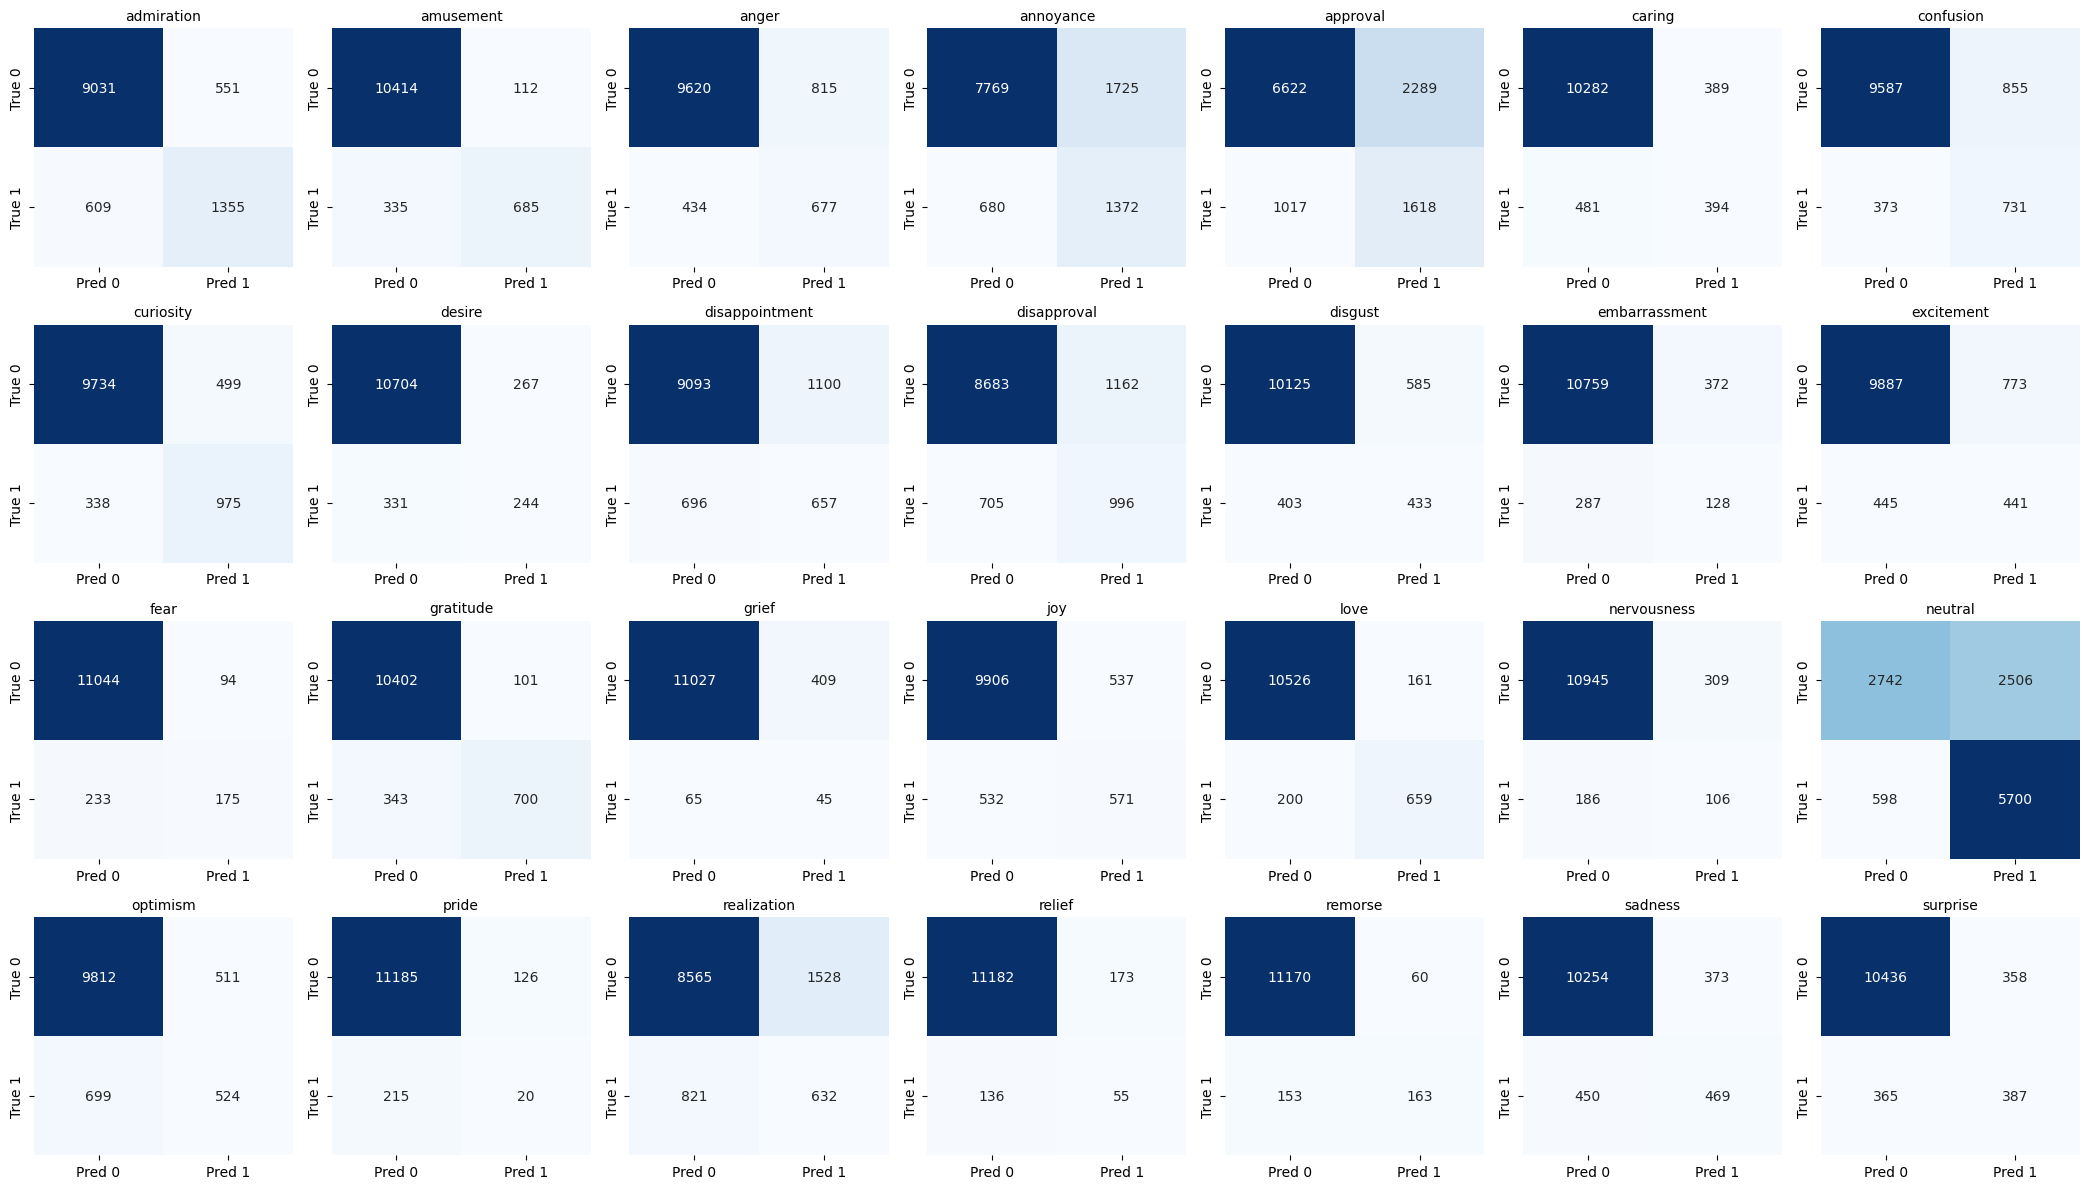

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set up the grid
rows, cols = 4, 7
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

pred = trainer_best.predict(preprocessed_test_data)
logits = pred.predictions
labels = pred.label_ids

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

try:
    best_thresholds = np.load("best_thresholds.npy")
    preds = (probs > best_thresholds).astype(int)
except FileNotFoundError:
    print("Best thresholds not found. Using default threshold of 0.5.")
    preds = (probs > 0.5).astype(int)


for i in range(len(label_cols)):
    cm = confusion_matrix(labels[:, i], preds[:, i], labels=[0, 1])

    # Handle edge case: only one class present
    if cm.shape != (2, 2):
        full_cm = np.zeros((2, 2), dtype=int)
        full_cm[:cm.shape[0], :cm.shape[1]] = cm
        cm = full_cm

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_title(label_cols[i], fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

for j in range(len(label_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipython-input-962767834.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')


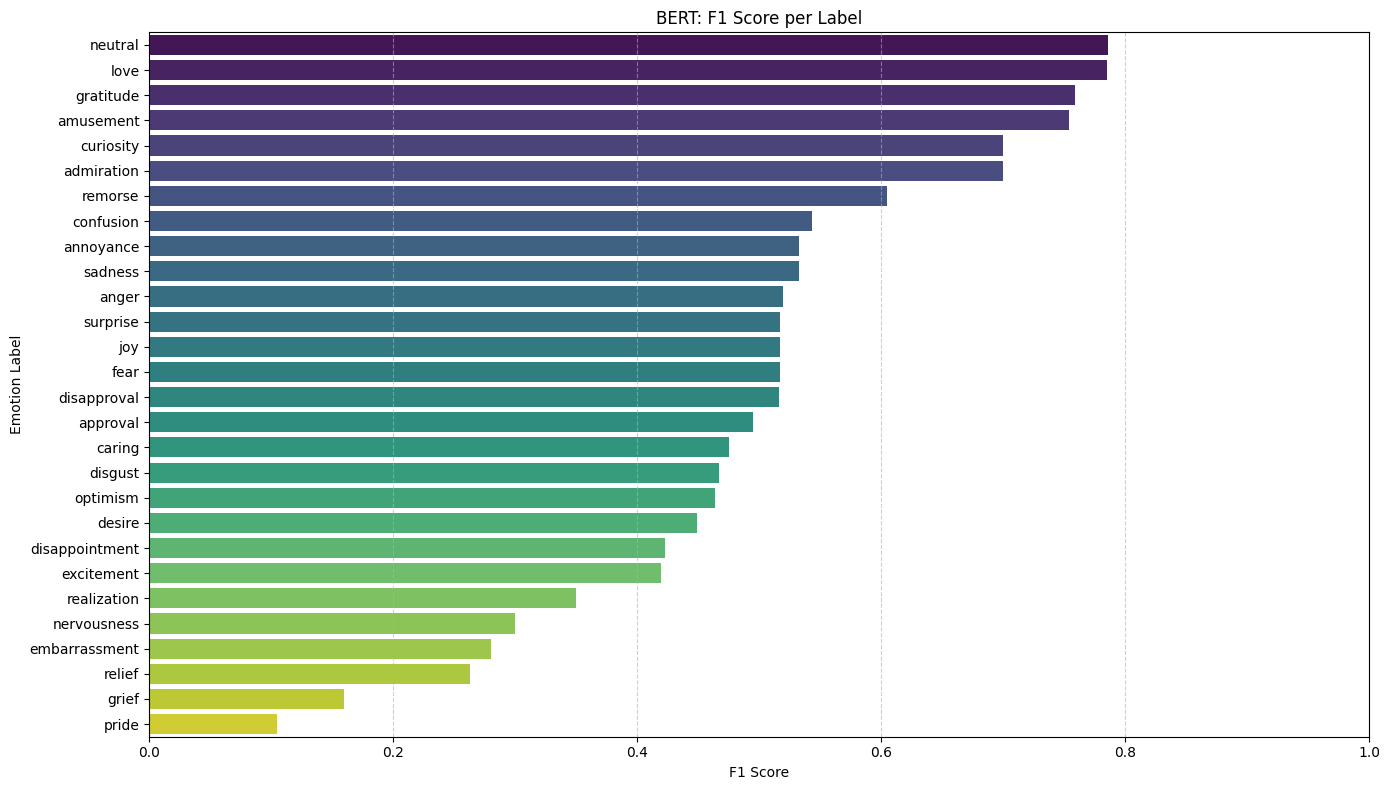

In [23]:
# Sort by F1 score for better visualization
df_sorted = confusion_summary_df.sort_values(by='F1 Score', ascending=False)

# Set figure size
plt.figure(figsize=(14, 8))

# Plot F1 Score bar chart
sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')

plt.title('BERT: F1 Score per Label')
plt.xlabel('F1 Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

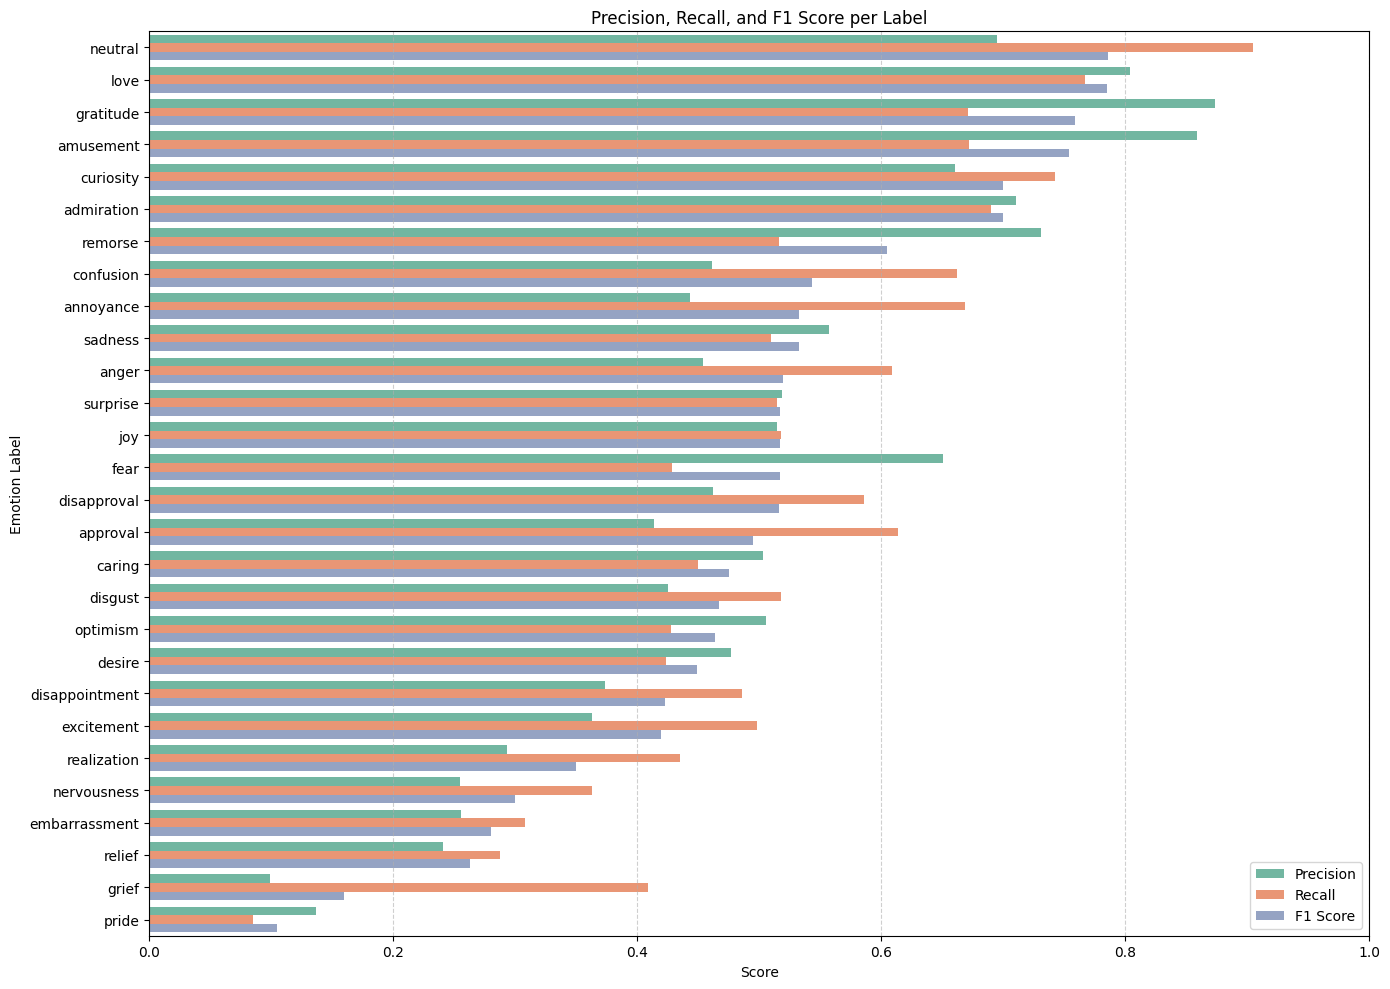

In [24]:
# Melt the DataFrame to long format for Seaborn
metrics_df = df_sorted[['Label', 'Precision', 'Recall', 'F1 Score']].melt(id_vars='Label',
                                                                          var_name='Metric',
                                                                          value_name='Score')

plt.figure(figsize=(14, 10))
sns.barplot(data=metrics_df, x='Score', y='Label', hue='Metric', palette='Set2')

plt.title('Precision, Recall, and F1 Score per Label')
plt.xlabel('Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

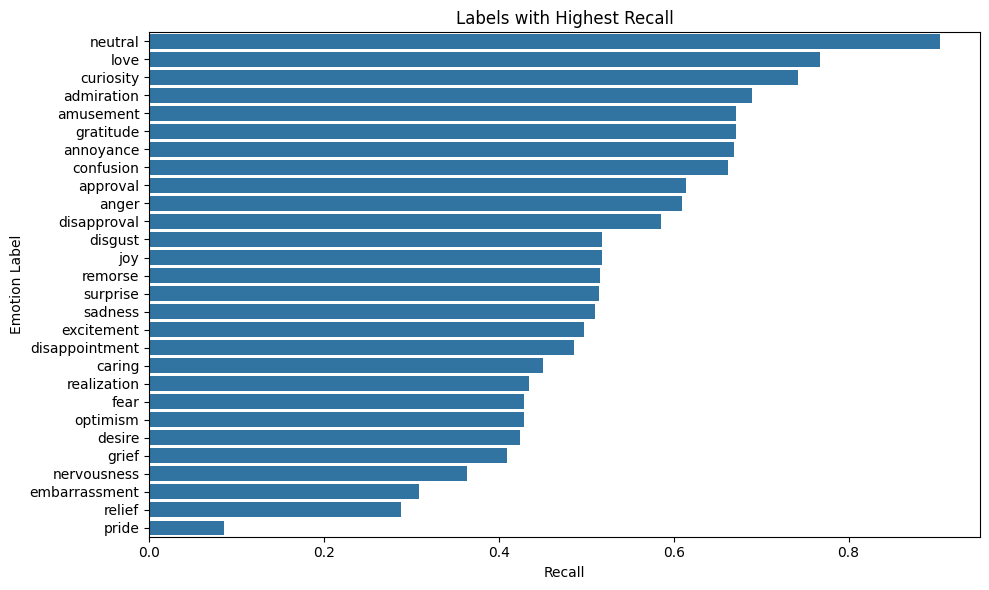

In [25]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 for each label
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

# Put into a DataFrame
metric_df = pd.DataFrame({
    'Label': label_cols,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
})

# Sort by Recall
top_recall = metric_df.sort_values(by='Recall', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Recall', y='Label', data=top_recall)
plt.title('Labels with Highest Recall')
plt.xlabel('Recall')
plt.ylabel('Emotion Label')
plt.tight_layout()
plt.show()


/tmp/ipython-input-4154161438.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-4154161438.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-4154161438.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')


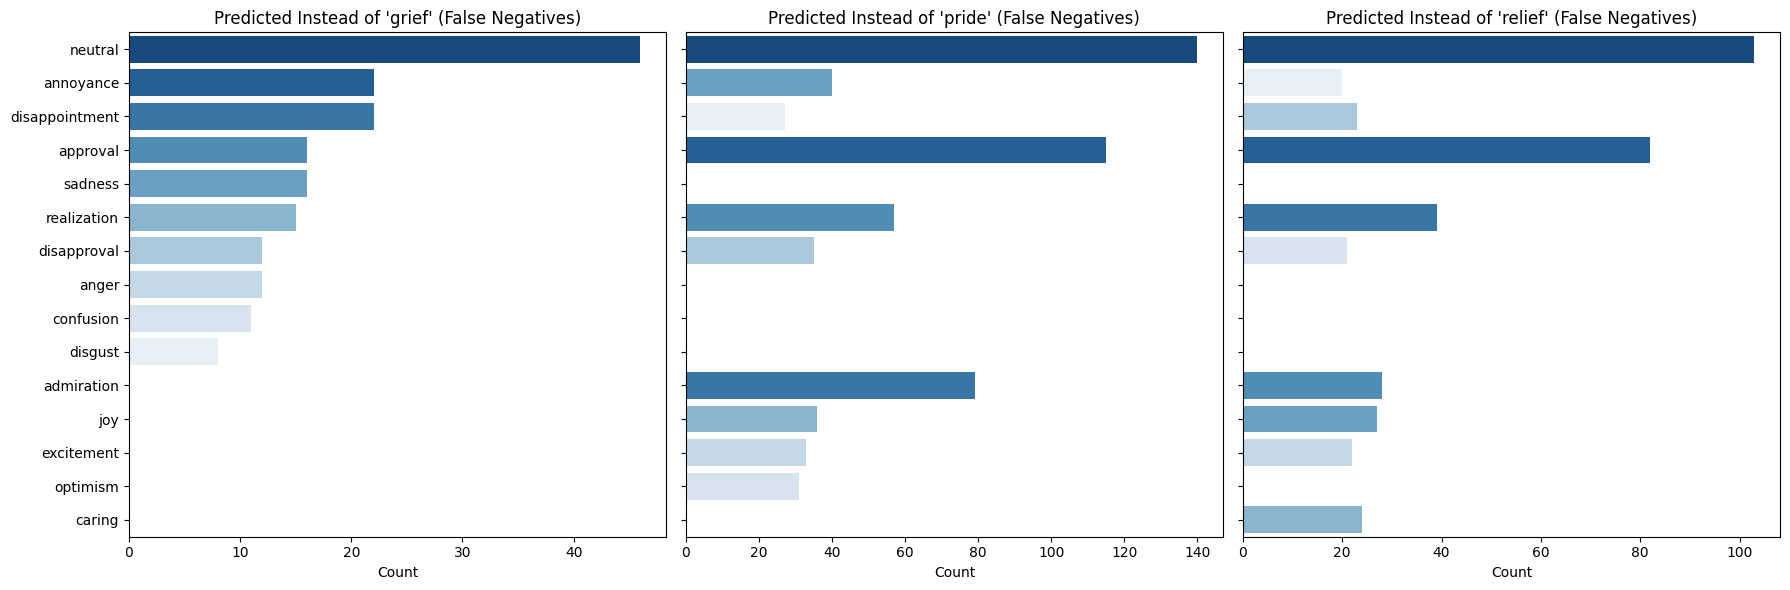

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Labels to analyze
target_labels = ['grief','pride', 'relief']

# Convert to list if it's a Pandas Index
label_cols = list(label_cols)

# Store co-predicted label counts
co_predicted_counts = {}

for target in target_labels:
    idx = label_cols.index(target)

    fn_mask = (labels[:, idx] == 1) & (preds[:, idx] == 0)

    other_preds = preds[fn_mask]

    counts = np.sum(other_preds, axis=0)
    counts[idx] = 0
    co_predicted_counts[target] = pd.Series(counts, index=label_cols)


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, target in zip(axes, target_labels):
    top_preds = co_predicted_counts[target].sort_values(ascending=False)[:10]

    sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
    ax.set_title(f"Predicted Instead of '{target}' (False Negatives)")
    ax.set_xlabel("Count")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


_________________________________________________________________________________________
# Training 6 Binary Models


Top 3 Labels  
* love
* gratitude
* amusement

Bottom 3 Labels
* relief
* pride
* grief

In [28]:
## labels of interest

MAX_SEQUENCE_LENGTH = 35

target_labels = [ 'love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']
bert_model_trainer = {}

model_checkpoint_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_checkpoint_name)

################################################################################
# Function to tokenize and extract binary label
def preprocess_binary_label(data, tokenizer, target_label):
    # Tokenize the 'text' data
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Convert the binary label to integer type
    encoded["labels"] = [int(x) for x in data[target_label]]  # Convert to integer for cross_entropy
    return encoded

################################################################################
# Function for computing metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits has shape (batch_size, num_labels)
    preds = logits.argmax(axis=-1)   # shape (batch_size,), values in {0,1}

    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "precision":        precision_score(labels, preds, average='binary', zero_division=0),
        "recall":           recall_score(labels, preds, average='binary', zero_division=0),
        "f1":               f1_score(labels, preds, average='binary', zero_division=0)
    }

################################################################################

# Train binary classifiers
for label in target_labels:

    bert_model = BertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=2, problem_type="single_label_classification")

    train_df = train_dataset.to_pandas()[['text', label]]
    val_df = val_dataset.to_pandas()[['text', label]]

    # Balance the training set (50% positive, 50% negative)
    train_pos = train_df[train_df[label] == 1]
    train_neg = train_df[train_df[label] == 0]

    if len(train_pos) < len(train_neg):
        train_neg = train_neg.sample(n=len(train_pos), random_state=42)
    else:
        train_pos = train_pos.sample(n=len(train_neg), random_state=42)

    train_balanced = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42)
    train_balanced_dataset = Dataset.from_pandas(train_balanced)
    val_dataset_filtered = Dataset.from_pandas(val_df)

    # Tokenize datasets
    train_encoded = train_balanced_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )
    val_encoded = val_dataset_filtered.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"{label}_emotion_model",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to="none",
        logging_strategy="epoch"
    )

    # Trainer
    trainer = Trainer(
        model=bert_model,
        args=training_args,
        train_dataset=train_encoded,
        eval_dataset=val_encoded,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print(f"\nTraining binary classifier for '{label}'...\n")
    trainer.train()
    bert_model_trainer[label] = trainer


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1893958264.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'love'...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.357800,0.226100,0.926122,0.507277,0.837529,0.631852
2,0.230500,0.329966,0.906981,0.441107,0.856979,0.582426


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6412 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1893958264.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'gratitude'...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.370900,0.294787,0.882557,0.426586,0.886429,0.575985
2,0.275000,0.320564,0.898320,0.465473,0.875842,0.607882


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6166 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1893958264.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'amusement'...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.423900,0.330502,0.945089,0.689803,0.747447,0.717469
2,0.328900,0.319258,0.886541,0.441132,0.810585,0.571335


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1893958264.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'relief'...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.622500,0.735867,0.709943,0.051892,0.811659,0.097548
2,0.353200,0.695368,0.755673,0.062332,0.829596,0.115951


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1362 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1893958264.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'pride'...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.630100,0.505347,0.778018,0.056561,0.710900,0.104785
2,0.333600,0.679894,0.742941,0.049363,0.715640,0.092355


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1893958264.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'grief'...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.622100,0.870984,0.585831,0.019737,0.872727,0.038601
2,0.348600,0.765246,0.724580,0.028852,0.854545,0.055819


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


#### Evaluating using Test set

In [29]:

summary_metrics = []
error_rates = []

for label in target_labels:
    # 1) Tokenize the test split for this label
    test_enc = test_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label),
        batched=True
    )

    # 2) Predict
    logits, label_ids, _ = bert_model_trainer[label].predict(test_enc)
    preds = logits.argmax(axis=-1)

    # 3) Performance summary
    acc  = accuracy_score(label_ids, preds)
    prec = precision_score(label_ids, preds, zero_division=0)
    rec  = recall_score(label_ids, preds, zero_division=0)
    f1   = f1_score(label_ids, preds, zero_division=0)

    summary_metrics.append({
        'label':    label,
        'accuracy':  acc,
        'precision': prec,
        'recall':    rec,
        'f1_score':  f1
    })

    # 4) Confusion matrix rates
    tn, fp, fn, tp = confusion_matrix(label_ids, preds).ravel()
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate

    error_rates.append({
        'label':                   label,
        'true_negative_rate':      tnr,
        'false_positive_rate':     fpr,
        'false_negative_rate':     fnr,
        'true_positive_rate':      tpr,
    })

# 5) Build DataFrames
df_summary     = pd.DataFrame(summary_metrics)
df_error_rates = pd.DataFrame(error_rates)

# 6) Display or save
print("=== Performance Summary ===")
print(df_summary.to_string(index=False))
print("\n=== Error Rates ===")
print(df_error_rates.to_string(index=False))


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


=== Performance Summary ===
    label  accuracy  precision   recall  f1_score
     love  0.909839   0.446596 0.885914  0.593835
gratitude  0.896414   0.461187 0.871524  0.603185
amusement  0.883336   0.417798 0.814706  0.552343
   relief  0.759051   0.054045 0.821990  0.101421
    pride  0.741989   0.049573 0.642553  0.092045
    grief  0.722068   0.028311 0.845455  0.054786

=== Error Rates ===
    label  true_negative_rate  false_positive_rate  false_negative_rate  true_positive_rate
     love            0.911762             0.088238             0.114086            0.885914
gratitude            0.898886             0.101114             0.128476            0.871524
amusement            0.889987             0.110013             0.185294            0.814706
   relief            0.757992             0.242008             0.178010            0.821990
    pride            0.744054             0.255946             0.357447            0.642553
    grief            0.720881             0.27911

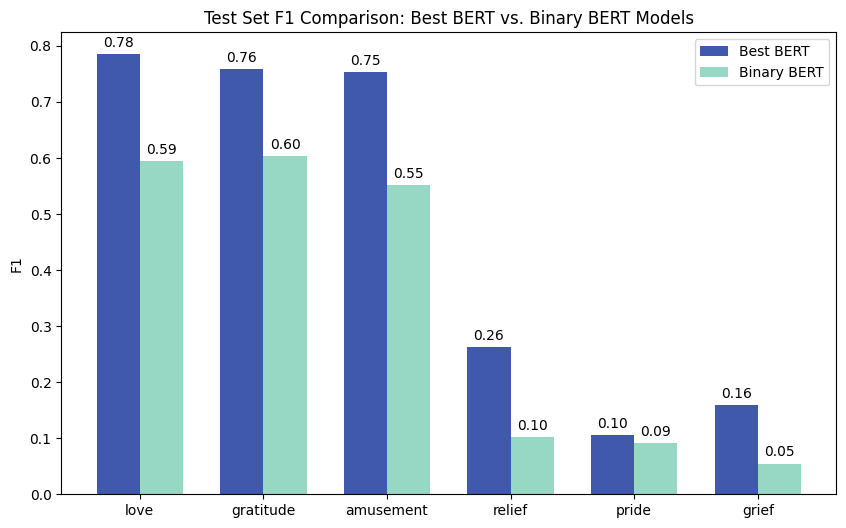

In [30]:
target_labels = [ 'love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']
# Best BERT model F1 results from test set: weights, thresholds
bert_best_model = [0.784991, 0.759219,  0.753990,  0.262530,  0.104987,  0.159574]
# BERT binary results from test set
binary_bert = [ 0.593835,0.603185, 0.552343,  0.101421,0.092045,0.054786]

# creating bar graph
x= np.arange(len(target_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bert_best_model, width, label='Best BERT',color='#4059AD')
rects2 = ax.bar(x + width/2, binary_bert, width, label='Binary BERT', color='#97D8C4')

ax.set_ylabel('F1')
ax.set_title('Test Set F1 Comparison: Best BERT vs. Binary BERT Models')
ax.set_xticks(x)
ax.set_xticklabels(target_labels)
ax.legend()

ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

plt.show()
